In [31]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display

In [3]:
# custom module
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = tuple(map(int,args))
    def forward(self, x):
        return x.view((x.shape[0],)+self.shape)

In [5]:
# architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution layers and max pooling of encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,(3,3),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,8,(3,3),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8,8,(3,3),padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(2,padding=1),
            torch.nn.Flatten()
        )
        # convolution layers and upsampling of decoder
        self.decoder = nn.Sequential(
            Reshape(8,4,4),
            nn.Conv2d(8,8,(3,3),padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(8,8,(3,3),padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(8,16,(3,3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(16,1,(3,3),padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # apply encoder
        features = self.encoder(x)
        # apply decoder
        return self.decoder(features)
    def __str__(self):
        return str(self.encoder)+str(self.decoder)

In [6]:
autoencoder = Autoencoder()

In [8]:
model_name = 'pytorch_mnist_autoencoder_model.pth'
from google.colab import files
print('upload',model_name)
files.upload()
autoencoder.load_state_dict(torch.load(model_name))

upload pytorch_mnist_autoencoder_model.pth


Saving pytorch_mnist_autoencoder_model.pth to pytorch_mnist_autoencoder_model.pth


<All keys matched successfully>

In [9]:
decoder = autoencoder.decoder
decoder.eval()

Sequential(
  (0): Reshape()
  (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=(2.0, 2.0), mode='nearest')
  (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Upsample(scale_factor=(2.0, 2.0), mode='nearest')
  (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): Upsample(scale_factor=(2.0, 2.0), mode='nearest')
  (10): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Sigmoid()
)

In [10]:
print('upload inp00009.png')
_ = files.upload()

upload inp00009.png


Saving inp00009.png to inp00009.png


In [11]:
sample_image = cv2.imread('inp00009.png',cv2.IMREAD_GRAYSCALE)
sample_blob = cv2.dnn.blobFromImage(sample_image,1.0/255.0)
sample_features = autoencoder.encoder(torch.tensor(sample_blob))
features = sample_features.squeeze(0).detach().cpu().numpy()

In [12]:
print(sample_features.shape)

torch.Size([1, 128])


In [18]:
# Keep a copy of features for updating
features = sample_features[0].clone().detach()
last_features = features.clone().detach()
last_features[0] = 1.0  # example of modification

In [36]:
# Function to update and display the generated image
def update_latent(index=0, value=64):
    global features, last_features
    features[index] = value / 127.0
    if (features != last_features).sum() > 0:
        last_features = features
        coded = features.unsqueeze(0)
        with torch.no_grad():
            decoded = decoder(coded).detach().squeeze(0).numpy() * 255
        decoded = decoded.astype(np.uint8)
        print(decoded.shape, decoded.min(), decoded.max())
        decoded_resized = cv2.resize(decoded, (560, 560), interpolation=cv2.INTER_NEAREST)
        plt.clf()
        plt.figure(figsize=(6,6))
        plt.imshow(decoded_resized, cmap='gray')
        plt.axis('off')
        plt.show()

In [28]:
# Interactive sliders for latent space
latent_dim = features.shape[0]
index_slider = IntSlider(min=0, max=latent_dim-1, step=1, value=0, description='Index')
value_slider = IntSlider(min=0, max=127, step=1, value=int(features[0].item()*127), description='Value')

In [29]:
def interactive_update(index, value):
    update_latent(index, value)

interactive(children=(IntSlider(value=24, description='Index', max=127), IntSlider(value=90, description='Valu…

<function __main__.interactive_update(index, value)>

<Figure size 640x480 with 0 Axes>

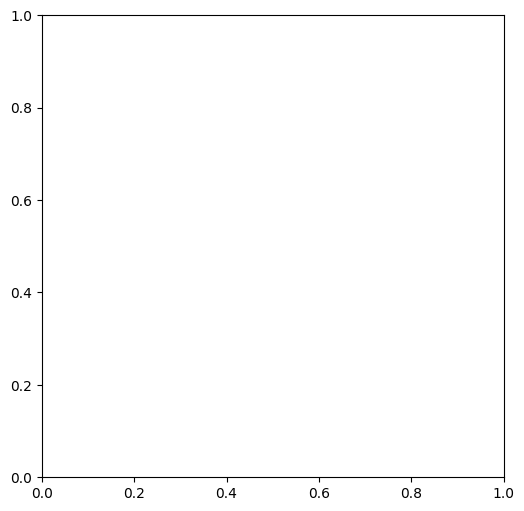

<Figure size 640x480 with 0 Axes>

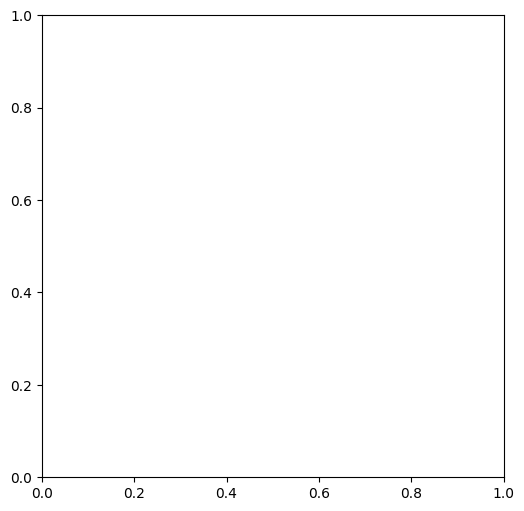

<Figure size 640x480 with 0 Axes>

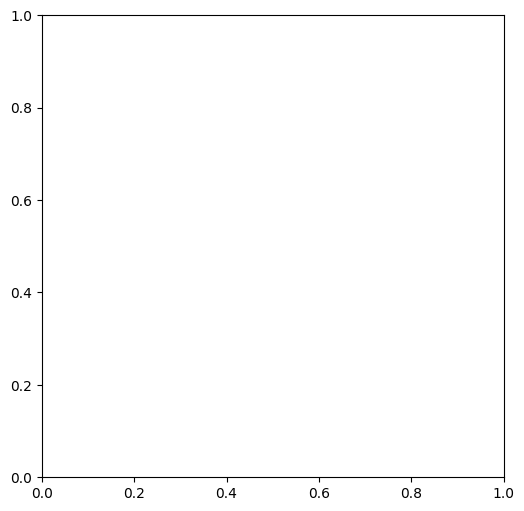

<Figure size 640x480 with 0 Axes>

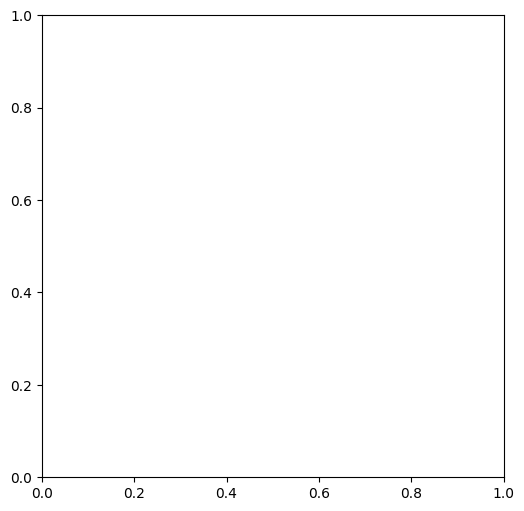

In [37]:
interact(interactive_update, index=index_slider, value=value_slider)